# Plot the equatorial precipitation-SST point-wise regression results 


In [1]:
import xarray as xr
import xarray as xr
import pandas as pd
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import numpy as np
from scipy.stats import linregress
from scipy import stats
from itertools import cycle
import cftime
from cmip_postprocess import *
from cmip_plot import plot_all_reg_cor_map
import warnings 
warnings.filterwarnings('ignore')

2025-01-21 12:00:28.155808


## 1. load the data

In [2]:
# Path to the data
SSTA_PATH = '../data/processed/SSTA/'
SSTA_INDEX_PATH = '../data/processed/SSTA_INDEX/'
PRCP_ANO_PATH = '../data/processed/PRCP_ANOMALY/'
source_id = '../data/raw/source_id.txt'

OUT_REG_PATH = '../data/processed/regression/'
OUT_FIG_PATH = '../results/figures/'

In [3]:
lpf_ssta = load_from_pickle(SSTA_PATH + 'lpf_ssta.pkl')
lpf_prcp_ano = load_from_pickle(PRCP_ANO_PATH + 'lpf_ano_prcp.pkl')

In [4]:
# load the model ranking data
model_ranking = pd.read_csv('../data/processed/model_ranking.csv', index_col=0)

# sort the model by distance
model_ranking = model_ranking.sort_values('Distance')

# select the high skill models (Distance < 1) and low skill models (Distance > 1.5)
high_skill_models = model_ranking[model_ranking['Distance'] < 1].index.tolist()
high_skill_models = [model for model in high_skill_models if model != 'E3SMv2']
low_skill_models = model_ranking[model_ranking['Distance'] > 1.5].index.tolist()
low_skill_models = [model for model in low_skill_models if model != 'E3SM-MMF']


In [5]:
# rename the keys of lpf_ssta to match lpf_prcp_ano
lpf_ssta_new = {}
for key in lpf_ssta.keys():
    # extract the model name (remove the .r1i1p1f1 etc suffix)
    model_name = key.split('.')[0]
    lpf_ssta_new[model_name] = lpf_ssta[key]
lpf_ssta = lpf_ssta_new

# rename the keys of lpf_prcp_ano to match lpf_ssta
lpf_prcp_ano_new = {}
for key in lpf_prcp_ano.keys():
    # extract the model name (remove the .r1i1p1f1 etc suffix)
    model_name = key.split('.')[0]  
    lpf_prcp_ano_new[model_name] = lpf_prcp_ano[key]
lpf_prcp_ano = lpf_prcp_ano_new


## 2. calculate the equatorial precipitation-SST point-wise regression

In [6]:
def calculate_regression_vectorize(data1, data2, coord_name='time'):
    """
    Calculate regression between two 3D datasets with different time formats.
    
    Parameters:
    -----------
    data1 : xarray.DataArray
        First 3D data array (time, lat, lon)
    data2 : xarray.DataArray
        Second 3D data array (time, lat, lon)
    coord_name : str, optional
        Name of the time coordinate, default is 'time'
        
    Returns:
    --------
    xarray.Dataset
        Dataset containing regression results
    """
    
  
    if not data1[coord_name].equals(data2[coord_name]):
        # find the common time points
        common_times = data1[coord_name].isin(data2[coord_name])
        data1 = data1.sel({coord_name: data1[coord_name][common_times]})
        data2 = data2.sel({coord_name: data1[coord_name]})
    
    # align the datasets
    data1, data2 = xr.align(data1, data2, join='inner', copy=False)
    
    def linear_regression(x, y):
        """Calculate linear regression between two 1D arrays."""
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 2:  # Ensure at least 3 valid points
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
                return slope, intercept, r_value, p_value, std_err
            except:
                return np.nan, np.nan, np.nan, np.nan, np.nan
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Apply regression along time dimension
    regression_results = xr.apply_ufunc(
        linear_regression,
        data1,
        data2,
        input_core_dims=[[coord_name], [coord_name]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        output_dtypes=[float, float, float, float, float]
    )
    
    # Create dataset with results
    regression_ds = xr.Dataset({
        'slope': regression_results[0],
        'intercept': regression_results[1],
        'r_value': regression_results[2],
        'p_value': regression_results[3],
        'std_err': regression_results[4]
    })
    
    return regression_ds

In [7]:
def calculate_regression_vectorize(data1, data2, coord_name='time'):
    """
    Calculate regression between two 3D datasets with different time formats.
    Uses the minimum time length between the two datasets.
    """
    # Convert time to common format (year + month/12)
    def convert_time(time_vals):
        if isinstance(time_vals[0], (cftime._cftime.DatetimeNoLeap, 
                                   cftime._cftime.Datetime360Day,
                                   cftime._cftime.DatetimeJulian,
                                   cftime._cftime.DatetimeProlepticGregorian,
                                   cftime._cftime.DatetimeAllLeap)):
            return np.array([t.year + (t.month - 1)/12 for t in time_vals])
        elif isinstance(time_vals[0], np.datetime64):
            dates = pd.DatetimeIndex(time_vals)
            return dates.year + (dates.month - 1)/12
        else:
            try:
                dates = pd.to_datetime(time_vals)
                return dates.year + (dates.month - 1)/12
            except:
                return np.array([pd.Timestamp(t).year + (pd.Timestamp(t).month - 1)/12 
                               for t in time_vals])
    
    # Get time lengths and values
    time1 = convert_time(data1[coord_name].values)
    time2 = convert_time(data2[coord_name].values)
    
    # Find min time length
    min_time_length = min(len(time1), len(time2))
    print(f"Time lengths - Dataset 1: {len(time1)}, Dataset 2: {len(time2)}")
    print(f"Using minimum time length: {min_time_length}")
    
    # Get the common time period
    start_time = max(min(time1), min(time2))
    end_time = min(max(time1), max(time2))
    
    # Select data within the common time period
    mask1 = (time1 >= start_time) & (time1 <= end_time)
    mask2 = (time2 >= start_time) & (time2 <= end_time)
    
    data1_aligned = data1.isel({coord_name: mask1})
    data2_aligned = data2.isel({coord_name: mask2})
    
    # Ensure both datasets have the same length by taking the first min_time_length points
    data1_aligned = data1_aligned.isel({coord_name: slice(0, min_time_length)})
    data2_aligned = data2_aligned.isel({coord_name: slice(0, min_time_length)})
    
    # Create common time coordinate
    common_time = np.linspace(start_time, end_time, min_time_length)
    
    # Assign common time coordinate
    data1_aligned = data1_aligned.assign_coords({coord_name: common_time})
    data2_aligned = data2_aligned.assign_coords({coord_name: common_time})
    
    def linear_regression(x, y):
        """Calculate linear regression between two 1D arrays."""
        mask = ~np.isnan(x) & ~np.isnan(y)
        if np.sum(mask) > 2:
            try:
                slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
                return slope, intercept, r_value, p_value, std_err
            except:
                return np.nan, np.nan, np.nan, np.nan, np.nan
        return np.nan, np.nan, np.nan, np.nan, np.nan
    
    # Apply regression
    regression_results = xr.apply_ufunc(
        linear_regression,
        data1_aligned,
        data2_aligned,
        input_core_dims=[[coord_name], [coord_name]],
        output_core_dims=[[], [], [], [], []],
        vectorize=True,
        output_dtypes=[float, float, float, float, float]
    )
    
    # Create results dataset
    regression_ds = xr.Dataset({
        'slope': regression_results[0],
        'intercept': regression_results[1],
        'r_value': regression_results[2],
        'p_value': regression_results[3],
        'std_err': regression_results[4]
    })
    
    # Clean up
    import gc
    gc.collect()
    
    return regression_ds

In [8]:
# Calculate regression for all high-skill models
regression_results = {}
for model in lpf_ssta.keys():
    print(f"Calculating regression for {model}")
    regression_results[model] = calculate_regression_vectorize(lpf_ssta[model], lpf_prcp_ano[model])

Calculating regression for CESM2-WACCM
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for CESM2-WACCM-FV2
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for CESM2-FV2
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for CESM2
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for TaiESM1
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for GISS-E2-1-H
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for BCC-ESM1
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for NESM3
Time lengths - Dataset 1: 660, Dataset 2: 660
Using minimum time length: 660
Calculating regression for GISS-E2-1-G-CC
Time lengths - Dataset 1: 660, Dataset 2: 660
U

KeyError: 'HadISST'

### 2.1 calculate the regression for ERA5 and E3SMv2

In [9]:
# Calculate regression for ERA5 and E3SMv2
ersst_time = lpf_ssta['ERSST'].time.values
era5_time = lpf_prcp_ano['ERA5'].time.values
common_time = ersst_time[np.isin(ersst_time, era5_time)]
regression_results['ERA5'] = calculate_regression_vectorize(lpf_ssta['ERSST'].sel(time=common_time), lpf_prcp_ano['ERA5'].sel(time=common_time))


Time lengths - Dataset 1: 636, Dataset 2: 636
Using minimum time length: 636


In [10]:

e3smv2_ssta = lpf_ssta['E3SMv2'].copy()
e3smv2_prcp = lpf_prcp_ano['E3SMv2'].copy()

# create new time coordinates
new_times = [cftime.DatetimeNoLeap(pd.Timestamp(t).year, pd.Timestamp(t).month, 1) 
             for t in e3smv2_ssta.time.values]
e3smv2_ssta['time'] = new_times

# calculate the regression
common_times = e3smv2_ssta.time.isin(e3smv2_prcp.time)
regression_results['E3SMv2'] = calculate_regression_vectorize(
    e3smv2_ssta.sel(time=e3smv2_ssta.time[common_times]),
    e3smv2_prcp.sel(time=e3smv2_ssta.time[common_times])
)

Time lengths - Dataset 1: 659, Dataset 2: 659
Using minimum time length: 659


In [11]:
# convert the SST time of E3SM-MMF to the same format as the precipitation data
e3sm_mmf_ssta = lpf_ssta['E3SM-MMF'].copy()
e3sm_mmf_prcp = lpf_prcp_ano['E3SM-MMF'].copy()

# create new time coordinates
new_times = [cftime.DatetimeNoLeap(pd.Timestamp(t).year, pd.Timestamp(t).month, 1) 
             for t in e3sm_mmf_ssta.time.values]
e3sm_mmf_ssta['time'] = new_times

# calculate the regression
common_times = e3sm_mmf_ssta.time.isin(e3sm_mmf_prcp.time)
regression_results['E3SM-MMF'] = calculate_regression_vectorize(
    e3sm_mmf_ssta.sel(time=e3sm_mmf_ssta.time[common_times]),
    e3sm_mmf_prcp.sel(time=e3sm_mmf_ssta.time[common_times])
)

Time lengths - Dataset 1: 659, Dataset 2: 659
Using minimum time length: 659


In [14]:
len(regression_results.keys())

30

## 3. calculate the high-skill and low-skill MMM and STD of the regression results

In [13]:
# Calculate MMM and STD for slope
def calculate_slope_mmm(regression_results, model_list):
    """
    Calculate multi-model mean and standard deviation of slope for specified models.
    """
    # Stack all models' slopes
    model_slopes = []
    for model in model_list:
        if model in regression_results:
            model_slopes.append(regression_results[model]['slope'])
    
    # Convert to DataArray with model dimension
    stacked_slopes = xr.concat(model_slopes, dim='model')
    
    # Calculate mean and std along model dimension
    mmm = stacked_slopes.mean(dim='model')
    std = stacked_slopes.std(dim='model')
    
    return mmm, std

# Calculate for high-skill models
high_skill_mmm, high_skill_std = calculate_slope_mmm(regression_results, high_skill_models)
print(f"Number of high-skill models: {len(high_skill_models)}")

# Calculate for low-skill models
low_skill_mmm, low_skill_std = calculate_slope_mmm(regression_results, low_skill_models)
print(f"Number of low-skill models: {len(low_skill_models)}")

# Store results in a dataset
mmm_results = xr.Dataset({
    'high_skill_mmm': high_skill_mmm,
    'high_skill_std': high_skill_std,
    'low_skill_mmm': low_skill_mmm,
    'low_skill_std': low_skill_std
})

# Print basic statistics
print("\nHigh-skill models slope:")
print(f"MMM range: {high_skill_mmm.min().values:.3f} to {high_skill_mmm.max().values:.3f}")
print(f"STD range: {high_skill_std.min().values:.3f} to {high_skill_std.max().values:.3f}")

print("\nLow-skill models slope:")
print(f"MMM range: {low_skill_mmm.min().values:.3f} to {low_skill_mmm.max().values:.3f}")
print(f"STD range: {low_skill_std.min().values:.3f} to {low_skill_std.max().values:.3f}")

Number of high-skill models: 4
Number of low-skill models: 15

High-skill models slope:
MMM range: -0.001 to 0.003
STD range: 0.000 to 0.002

Low-skill models slope:
MMM range: -0.001 to 0.004
STD range: 0.000 to 0.004


## 4. save the regression results

In [ ]:
save_datasets_to_pickle(regression_results, PRCP_ANO_PATH + 'prcp_ssta_coupleing.pkl')

## 5. reload the regression results and plot the regression results

In [4]:
regression_results = load_from_pickle(PRCP_ANO_PATH + 'prcp_ssta_coupleing.pkl')

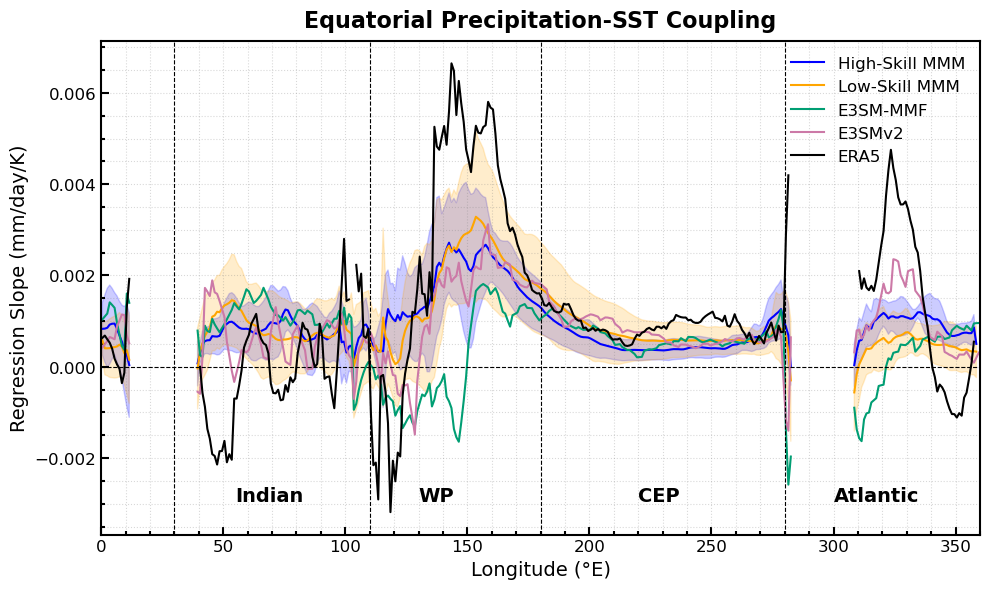

In [25]:
# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Set background grid
ax.grid(True, linestyle=':', color='gray', alpha=0.3, which='both')

# Plot high-skill MMM and STD range with blue
plt.plot(high_skill_mmm.lon, high_skill_mmm, 
         label='High-Skill MMM', color='blue', linewidth=1.5)
plt.fill_between(high_skill_mmm.lon, 
                 high_skill_mmm - high_skill_std,
                 high_skill_mmm + high_skill_std,
                 color='blue', alpha=0.2)

# Plot low-skill MMM and STD range with orange
plt.plot(low_skill_mmm.lon, low_skill_mmm, 
         label='Low-Skill MMM', color='orange', linewidth=1.5)
plt.fill_between(low_skill_mmm.lon,
                 low_skill_mmm - low_skill_std,
                 low_skill_mmm + low_skill_std,
                 color='orange', alpha=0.2)

# Plot special models with specific colors
colors = {
    'ERA5': 'black',
    'E3SMv2': '#CC79A7',  # Pink/Purple
    'E3SM-MMF': '#009E73'  # Changed to a green color
}

for model, zonal_mean in special_models.items():
    plt.plot(zonal_mean.lon, zonal_mean, 
             label=model, color=colors[model], linewidth=1.5)

# Add vertical separation lines (dashed)
for x in [30, 110, 180, 280]:
    plt.axvline(x, color='black', linestyle='--', linewidth=0.8)

# Add horizontal zero line (dashed)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Add region labels
y_position = ax.get_ylim()[0] * 0.8
plt.text(55, y_position, 'Indian', fontsize=14, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=14, fontweight='bold')
plt.text(220, y_position, 'CEP', fontsize=14, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=14, fontweight='bold')

# Set axis labels with larger, bolder font
plt.xlabel('Longitude (°E)', fontsize=14, )
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14, )
plt.title('Equatorial Precipitation-SST Coupling', 
          fontsize=16, fontweight='bold', pad=10)

# Set legend
plt.legend(frameon=False, loc='upper right', fontsize=12)

# Set tick parameters with bolder axes and larger font
ax.tick_params(which='both', direction='in', width=1.5)  # Make axis lines bolder
ax.tick_params(which='major', length=6, labelsize=12)    # Larger font for tick labels
ax.tick_params(which='minor', length=3)

# Make axis lines bolder
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Add minor ticks
ax.minorticks_on()

# Set x-axis range
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()

plt.show()

In [28]:
high_skill_models

['CanESM5', 'AWI-ESM-1-1-LR', 'CESM2-WACCM', 'MPI-ESM-1-2-HAM']

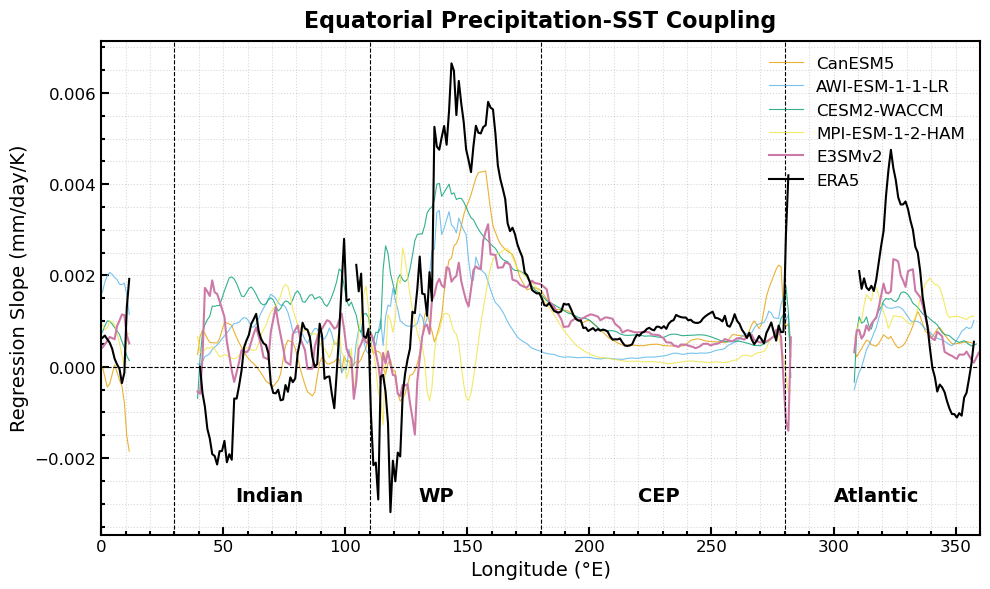

In [30]:
# Calculate zonal mean for 5S-5N region
high_skill_zonal = {}
special_models = {}

# Process models and calculate zonal means
for model, ds in regression_results.items():
    zonal_mean = ds.sel(lat=slice(-5, 5)).mean(dim='lat').slope
    if model in ['ERA5', 'E3SMv2']:  # Special models
        special_models[model] = zonal_mean
    elif model in high_skill_models:
        high_skill_zonal[model] = zonal_mean

# Create figure
fig, ax = plt.subplots(figsize=(10, 6))

# Set background grid
ax.grid(True, linestyle=':', color='gray', alpha=0.3, which='both')

# Define colors for high-skill models
high_skill_colors = {
    'CanESM5': '#E69F00',
    'AWI-ESM-1-1-LR': '#56B4E9',
    'CESM2-WACCM': '#009E73',
    'MPI-ESM-1-2-HAM': '#F0E442'
}

# Plot individual high-skill models with different colors
for model in high_skill_models:  # Use the order in high_skill_models list
    zonal_mean = high_skill_zonal[model]
    plt.plot(zonal_mean.lon, zonal_mean, 
             color=high_skill_colors[model], linewidth=0.8, alpha=0.8,
             label=model)

# Plot special models with specific colors
colors = {
    'ERA5': 'black',
    'E3SMv2': '#CC79A7',  # Pink/Purple
}

for model, zonal_mean in special_models.items():
    plt.plot(zonal_mean.lon, zonal_mean, 
             label=model, color=colors[model], linewidth=1.5)

# Add vertical separation lines (dashed)
for x in [30, 110, 180, 280]:
    plt.axvline(x, color='black', linestyle='--', linewidth=0.8)

# Add horizontal zero line (dashed)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Add region labels
y_position = ax.get_ylim()[0] * 0.8
plt.text(55, y_position, 'Indian', fontsize=14, fontweight='bold')
plt.text(130, y_position, 'WP', fontsize=14, fontweight='bold')
plt.text(220, y_position, 'CEP', fontsize=14, fontweight='bold')
plt.text(300, y_position, 'Atlantic', fontsize=14, fontweight='bold')

# Set axis labels with larger, bolder font
plt.xlabel('Longitude (°E)', fontsize=14, )
plt.ylabel('Regression Slope (mm/day/K)', fontsize=14, )
plt.title('Equatorial Precipitation-SST Coupling', 
          fontsize=16, fontweight='bold', pad=10)

# Set legend
plt.legend(frameon=False, loc='upper right', fontsize=12)

# Set tick parameters with bolder axes and larger font
ax.tick_params(which='both', direction='in', width=1.5)  # Make axis lines bolder
ax.tick_params(which='major', length=6, labelsize=12)    # Larger font for tick labels
ax.tick_params(which='minor', length=3)

# Make axis lines bolder
for spine in ax.spines.values():
    spine.set_linewidth(1.5)

# Add minor ticks
ax.minorticks_on()

# Set x-axis range
plt.xlim(0, 360)

# Adjust layout
plt.tight_layout()

plt.show()